In [ ]:
from __future__ import print_function
import numpy as np
import csv, json
from zipfile import ZipFile
from os.path import expanduser, exists
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.data_utils import get_file
import pandas as pd
import string
import nltk
import pickle
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Download the input data from here 
# https://gist.github.com/W4ngatang/60c2bdb54d156a41194446737ce03e2e
# Download it using 

# python untitled.py --data_dir glue_data --tasks all

#Add the following lines in the  untitled.py to properly download the data

# import io
# URLLIB = urllib.request
# 'MRPC':'https://raw.githubusercontent.com/MegEngine/Models/master/official/nlp/bert/glue_data/MRPC/dev_ids.tsv' inside TASK2PATH 

# !python untitled.py --data_dir glue_data --tasks all

	Completed!
	Completed!
Processing MRPC...
	Completed!
	Completed!
	Completed!
	Note (12/10/20): This script no longer downloads SNLI. You will need to manually download and format the data to use SNLI.
	Completed!
	Completed!
	Completed!
	Completed!
	Completed!


In [ ]:
QUESTION_PAIRS_FILE = '/content/glue_data/MRPC/msr_paraphrase_train.txt'
QUESTION_PAIRS_FILE_TEST = '/content/glue_data/MRPC/msr_paraphrase_test.txt'
GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'

Q1_TESTING_DATA_FILE = 'q1_test.npy'
Q2_TESTING_DATA_FILE = 'q2_test.npy'
LABEL_TESTING_DATA_FILE = 'label_test.npy'

MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300

In [ ]:
def get_list(filename_path):
  """Read the data from file and return the relevant data in list

  Parameters:
  filename_path (str): Location of File

  Returns:
  list: sentence1
  list: sentence2
  list: label
  
  """
  print("Processing", filename_path)

  sentence1 = []
  sentence2 = []
  is_duplicate = []
  with open(filename_path, encoding='utf-8') as csvfile:
      fieldnames = ['label', 'id1', 'id2', 'sentence1', 'sentence2']
      reader  = pd.read_csv(filename_path, sep='\t', quoting=csv.QUOTE_NONE)
      reader.columns = fieldnames
      totalrows = 0
      for ind, row in reader.iterrows():
        totalrows+=1
        if row['sentence1'] is None:
          continue
        if row['sentence2'] is None:
          continue
        if row['label'] is None: 
          continue
        sentence1.append(row['sentence1'])
        sentence2.append(row['sentence2'])
        is_duplicate.append(row['label'])
      print(totalrows)

  print('Question pairs: %d' % len(sentence1))
  return sentence1, sentence2, is_duplicate

In [ ]:
sentence1, sentence2, is_duplicate= get_list(QUESTION_PAIRS_FILE)
sentence1_test, sentence2_test, is_duplicate_test= get_list(QUESTION_PAIRS_FILE_TEST)

Processing /content/glue_data/MRPC/msr_paraphrase_train.txt
4076
Question pairs: 4076
Processing /content/glue_data/MRPC/msr_paraphrase_test.txt
1725
Question pairs: 1725


In [ ]:
len(is_duplicate_test)

1725

In [ ]:
def remove_punctuation(list_of_test):
  """Preprocessing on input data. Removing stopwords, punctuation and making lowercase.

  Parameters:
  list_of_test (list): list of sentences 

  Returns:
  list: Processed List
  
  """
  final_list = []
  stopwords = nltk.corpus.stopwords.words('english')
  for x in list_of_test:
    punctuationfree="".join([i.lower() for i in x if i not in string.punctuation])
    filtered = ' '.join([word for word in punctuationfree.split() if word not in stopwords])
    final_list.append(filtered)
  return final_list

In [ ]:
sentence1 = remove_punctuation(sentence1)
sentence2 = remove_punctuation(sentence2)
sentence1_test = remove_punctuation(sentence1_test)
sentence2_test = remove_punctuation(sentence2_test)

In [ ]:
def my_tokenizer(sentence1, sentence2):
  """Tokenizes the input data

  Parameters:
  sentence1 (list): Sentence1
  sentence2 (list): Sentence2

  Returns:
  dict: word_index
  list: sentence1 word sequence
  list: sentence2 word sequence
  tokenizer: tokenizer fitted on train data
  
  """
  questions = sentence1 + sentence2
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
  tokenizer.fit_on_texts(questions)
  sentence1_word_sequences = tokenizer.texts_to_sequences(sentence1)
  sentence2_word_sequences = tokenizer.texts_to_sequences(sentence2)
  word_index = tokenizer.word_index

  print("Words in index: %d" % len(word_index))
  return word_index, sentence1_word_sequences, sentence2_word_sequences, tokenizer

In [ ]:
work_index, sentence1_word_sequences, sentence2_word_sequences, tokenizer = my_tokenizer(sentence1, sentence2)
sentence1_word_sequences_test = tokenizer.texts_to_sequences(sentence1_test)
sentence2_word_sequences_test = tokenizer.texts_to_sequences(sentence2_test)

Words in index: 14246


In [ ]:
# Downloading the GLove file and extracting embeddings_index

if not exists(GLOVE_ZIP_FILE):
    zipfile = ZipFile(get_file(GLOVE_ZIP_FILE, GLOVE_ZIP_FILE_URL))
    zipfile.extract(GLOVE_FILE)

2176768927/2176768927 [==============================] - 410s 0us/step


In [ ]:
print("Processing", GLOVE_FILE)

embeddings_index = {}
with open(GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

Processing glove.840B.300d.txt
Word embeddings: 2196016


In [ ]:
def get_embeddings(word_index):
  """Get embeddings matriz for the words in word_index

  Parameters:
  word_index (dict): word_index from tokenizer

  Returns:
  list: word_embedding_matrix
  int: number of words
  
  """  
  nb_words = min(MAX_NB_WORDS, len(word_index))
  word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
  for word, i in word_index.items():
      if i > MAX_NB_WORDS:
          continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          word_embedding_matrix[i] = embedding_vector

  print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))
  return word_embedding_matrix, nb_words

In [ ]:
word_embedding_matrix, nb_words = get_embeddings(work_index)

Null word embeddings: 1418


In [ ]:
def finaL_save(sentence1_word_sequences, sentence2_word_sequences, is_duplicate):
  """Add padding to the tokeinzed data

  Parameters:
  list: sentence1 word sequence
  list: sentence2 word sequence
  list: lables

  Returns:
  numpy.ndarray: Equal sized word sequence for sentence 1
  numpy.ndarray: Equal sized word sequence for sentence 1
  numpy.ndarray: labels
  
  """  
  q1_data = pad_sequences(sentence1_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
  q2_data = pad_sequences(sentence2_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
  labels = np.array(is_duplicate, dtype=int)
  print('Shape of sentence1 data tensor:', q1_data.shape)
  print('Shape of sentence2 data tensor:', q2_data.shape)
  print('Shape of label tensor:', labels.shape)
  return q1_data, q2_data, labels

In [ ]:
q1_data, q2_data, labels= finaL_save(sentence1_word_sequences, sentence2_word_sequences, is_duplicate)
q1_data_test, q2_data_test, labels_test= finaL_save(sentence1_word_sequences_test, sentence2_word_sequences_test, is_duplicate_test)

Shape of sentence1 data tensor: (4076, 25)
Shape of sentence2 data tensor: (4076, 25)
Shape of label tensor: (4076,)
Shape of sentence1 data tensor: (1725, 25)
Shape of sentence2 data tensor: (1725, 25)
Shape of label tensor: (1725,)


In [ ]:
np.save(open(Q1_TRAINING_DATA_FILE, 'wb'), q1_data)
np.save(open(Q2_TRAINING_DATA_FILE, 'wb'), q2_data)
np.save(open(LABEL_TRAINING_DATA_FILE, 'wb'), labels)
np.save(open(WORD_EMBEDDING_MATRIX_FILE, 'wb'), word_embedding_matrix)
with open(NB_WORDS_DATA_FILE, 'w') as f:
    json.dump({'nb_words': nb_words}, f)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
np.save(open(Q1_TESTING_DATA_FILE, 'wb'), q1_data_test)
np.save(open(Q2_TESTING_DATA_FILE, 'wb'), q2_data_test)
np.save(open(LABEL_TESTING_DATA_FILE, 'wb'), labels_test)

In [ ]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, Bidirectional, LSTM, dot, Flatten, Dense, Reshape, add, Dropout, BatchNormalization,TimeDistributed, Lambda, concatenate
from keras.layers import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras import backend as K
from sklearn.model_selection import train_test_split

In [ ]:
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'

Q1_TESTING_DATA_FILE = 'q1_test.npy'
Q2_TESTING_DATA_FILE = 'q2_test.npy'
LABEL_TESTING_DATA_FILE = 'label_test.npy'

MODEL_WEIGHTS_FILE = 'model_weights.h5'
MAX_SEQUENCE_LENGTH = 25
WORD_EMBEDDING_DIM = 300
SENT_EMBEDDING_DIM = 128
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25
DROPOUT = 0.2
BATCH_SIZE = 516

In [ ]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer2 = pickle.load(handle)

In [ ]:
q1_data.shape

(4076, 25)

In [ ]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

In [ ]:
sentence1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
sentence2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(sentence1)
q1 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q1)

q2 = Embedding(nb_words + 1, 
                 WORD_EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(sentence2)
q2 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q2)

attention = dot([q1,q2], [1,1])
attention = Flatten()(attention)
attention = Dense((MAX_SEQUENCE_LENGTH*SENT_EMBEDDING_DIM))(attention)
attention = Reshape((MAX_SEQUENCE_LENGTH, SENT_EMBEDDING_DIM))(attention)

merged = add([q1,attention])
merged = Flatten()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
# merged = Dense(200, activation='relu')(merged)
# merged = Dropout(DROPOUT)(merged)
# merged = BatchNormalization()(merged)
# merged = Dense(200, activation='relu')(merged)
# merged = Dropout(DROPOUT)(merged)
# merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[sentence1,sentence2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 300)      4274100     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 25, 300)      4274100     ['input_2[0][0]']                
                                                                                              

In [ ]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_accuracy', save_best_only=True), EarlyStopping(monitor='val_loss', mode='min', verbose=1)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2023-03-24 11:27:32.356029
Epoch 1/25
7/7 - 39s - loss: 0.8179 - accuracy: 0.5659 - val_loss: 1.2923 - val_accuracy: 0.4932 - 39s/epoch - 6s/step
Epoch 2/25
7/7 - 29s - loss: 0.6666 - accuracy: 0.6183 - val_loss: 0.8688 - val_accuracy: 0.6785 - 29s/epoch - 4s/step
Epoch 2: early stopping
Training ended at 2023-03-24 11:28:39.988074
Minutes elapsed: 1.127197


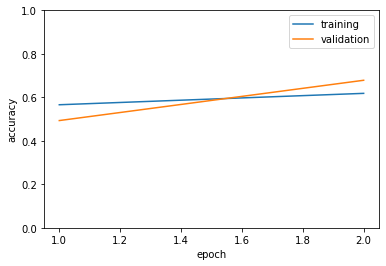

In [ ]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['accuracy'],
                    'validation': history.history['val_accuracy']})
ax = acc.set_index('epoch').plot()
# ax = acc.iloc[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

In [ ]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_accuracy']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 2 = 0.6785


In [ ]:
# model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([q1_data_test, q2_data_test], np.asarray(is_duplicate_test), verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))
# loss = 0.7759, accuracy = 0.6858

loss = 0.9138, accuracy = 0.6841


In [ ]:
model.save(MODEL_WEIGHTS_FILE)

In [ ]:
# model.load_weights(MODEL_WEIGHTS_FILE)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

y_pred_actuals = model.predict([q1_data_test, q2_data_test])

54/54 [==============================] - 9s 108ms/step


In [ ]:
MODEL_THRESHOLD = 0.8
y_pred =(y_pred_actuals>MODEL_THRESHOLD)
list(y_pred)

cm = confusion_matrix(is_duplicate_test, y_pred)
print(cm)
print(precision_score(is_duplicate_test, y_pred , average="macro"))
print(recall_score(is_duplicate_test, y_pred , average="macro"))
print("F1 Score", f1_score(is_duplicate_test, y_pred , average="macro"))
print("Accuracy", accuracy_score(is_duplicate_test, y_pred))

[[210 368]
 [274 873]]
0.5686746225717729
0.5622188769861501
F1 Score 0.5633180024415865
Accuracy 0.6278260869565218


In [ ]:
from collections import Counter
print(Counter(list(y_train)))
print(Counter(list(is_duplicate_test)))
print(Counter(list(y_pred.flatten())))

Counter({1: 2467, 0: 1201})
Counter({1: 1147, 0: 578})
Counter({True: 1241, False: 484})


In [ ]:
# !pip list